In [1]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

# Metemos un gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.impute import SimpleImputer


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
# Según el criterio chi-squared dustribution for it to have three features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest


# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [2]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])
# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

In [3]:
## ENCODING

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 


In [4]:
def preprocesar(df_train=None, df_test=None, escalar=True, tipo_scaler='standar', tipo_imputer='mediana',n_vecinos_knn_imputer = None ):
  # Preprocesamiento para TRAIN
  df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
  train_ID = df_train['ID'].copy()
  train_RATE = df_train['RATE'].copy()
  # Preprocesamiento para TEST
  df_final_test = df_test.drop('ID', axis=1, inplace=False)
  test_ID = df_test['ID'].copy()


  # TIPO ESCALADO

  if(escalar):
    if(tipo_scaler == 'minmax'):
      scaler = MinMaxScaler()
    elif(tipo_scaler == 'standar'):
      scaler = StandardScaler()
    elif(tipo_scaler == 'robust'):
      scaler = RobustScaler()
    else:
      scaler = MinMaxScaler()
    
    df_scaled = scaler.fit_transform(df_final_train.to_numpy())
    df_scaled = pd.DataFrame(df_scaled,index=df_final_train.index, columns=[df_final_train.columns])

    df_scaled_test = scaler.transform(df_final_test.to_numpy())
    df_scaled_test = pd.DataFrame(df_scaled_test,index=df_final_test.index, columns=[df_final_test.columns])

  else:
    df_scaled = df_final_train
    df_scaled_test = df_final_test
  
  
  
  # TIPO IMPUTACIÓN
  
  if(tipo_imputer == 'knn'):
    
    imp_train = KNNImputer(n_neighbors=n_vecinos_knn_imputer).fit(df_scaled)
    imputed_X_train = pd.DataFrame(imp_train.transform(df_scaled), columns=df_scaled.columns)

    imp_test = KNNImputer(n_neighbors=n_vecinos_knn_imputer).fit(df_scaled_test)
    imputed_X_test = pd.DataFrame(imp_test.transform(df_scaled_test), columns=df_scaled_test.columns)

  elif(tipo_imputer == 'mediana'):
    imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_scaled)
    imputed_X_train = pd.DataFrame(imp_train.transform(df_scaled), columns=df_scaled.columns)
    
    imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_scaled_test)
    imputed_X_test = pd.DataFrame(imp_test.transform(df_scaled_test), columns=df_scaled_test.columns)
    
  elif(tipo_imputer == 'moda'):
    
    imp_train = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(df_scaled)
    imputed_X_train = pd.DataFrame(imp_train.transform(df_scaled), columns=df_scaled.columns)
    
    imp_test = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(df_scaled_test)
    imputed_X_test = pd.DataFrame(imp_test.transform(df_scaled_test), columns=df_scaled_test.columns)
    
  else:
    
    df_scaled = df_final_train
    df_scaled_test = df_final_test


  # Componer las columnas a devolver
  columns = ['ID']
  columns = np.append(columns, df_final_train.columns)
  columns = np.append(columns, 'RATE')

  result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
  result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
  result_df_train.columns = columns

  columns = ['ID']
  columns = np.append(columns, df_final_test.columns)
  
  result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
  result_df_test.columns = columns

  return result_df_train, result_df_test


In [5]:
# df_train_encoded
# df_test_encoded

In [6]:
## PREPROCESAMIENTO

np.random.seed(1234)

df_train = df_train_encoded
df_test = df_test_encoded


# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()



<Axes: xlabel='column', ylabel='value'>

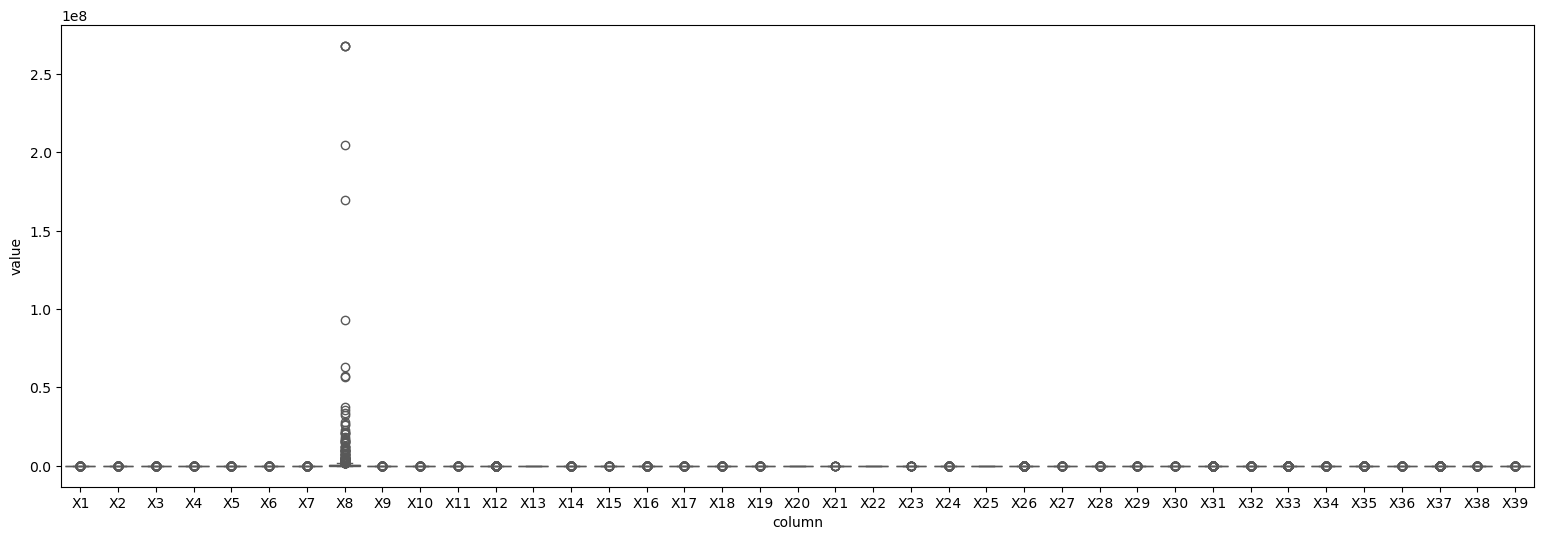

In [7]:

df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X6','X7','X10','X11']])


df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(19,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [8]:
# df_train_copy
# df_test_copy

In [9]:
#1. Quitar outliers

modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na = df_train_copy.dropna(axis=0, inplace=False)

modelo_isof.fit(X=df_no_na)
clasificacion_predicha = modelo_isof.predict(X=df_no_na)
clasificacion_predicha

df_no_na['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na.index[df_no_na['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers = df_train_copy.drop(index=indices_outliers)

# Ahora, imputo sobre el dataset sin outliers
imp_train = KNNImputer(n_neighbors=5).fit(df_no_outliers)
df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers) #most_frequent
# df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# Hago lo mismo para test

modelo_isof_test = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na_test = df_test_copy.dropna(axis=0, inplace=False)

modelo_isof_test.fit(X=df_no_na_test)
clasificacion_predicha = modelo_isof_test.predict(X=df_no_na_test)
clasificacion_predicha

df_no_na_test['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na_test.index[df_no_na_test['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers_test = df_test_copy.drop(index=indices_outliers)


imp_test = KNNImputer(n_neighbors=5).fit(df_no_outliers_test)
df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

#Imputamos con mediana

# imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers_test)
# df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)



In [10]:
# df_train_imp
# df_test_imp

In [11]:
# # 4. Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
df_scaled = pd.DataFrame(df_scaled,index=df_train_imp.index, columns=[df_train_imp.columns])

df_scaled_test = scaler.transform(df_test_imp.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_test_imp.index, columns=[df_test_imp.columns])


# # 5. Componemos las columnas
columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_scaled_test, left_index=True, right_index=True)
result_df_test.columns = columns
  

In [79]:
# result_df_train
# result_df_test

In [18]:

# 6. ENTRENAMIENTO

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train_split, X_validacion, y_train_split, y_validacion = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=True)

# X_train, X_test, y_train, y_test = train_test_split(X_train_split, y_train_split, test_size=0.1, random_state = 32, shuffle=True)


print(sorted(Counter(y_train_split).items()))
# [('A', 47), ('B', 245), ('C', 149), ('D', 129)]

#, sampling_strategy=0.8
undersampler = RandomUnderSampler(random_state=0) #undersampling technique
undersampler_2 = RandomUnderSampler(random_state=0) #undersampling technique
undersampler_3 = RandomUnderSampler(random_state=0) #undersampling technique
oversampler = SMOTE(random_state=0) #oversampling technique
model = KNeighborsClassifier() #classification model

#Instantiate the pipeline
pipeline = Pipeline([
    ('undersampler', undersampler),
    ('oversampler', oversampler),
    ('model', model)
])


us_strategy = [
    {'B': 110},{'B':220}, {'B':210}, {'B':200},
    {'B':170}, {'B':180}, {'B':150}, {'B':140}
]

us_strategy_2 = [
    {'C': 110},{'C':100}, {'C':90}, {'C':70},
    {'C':130}, {'C':140}
]

us_strategy_3 = [
    {'D': 110},{'D':100}, {'D':90}, {'D':70}
]

os_strategy = [
    {'A':60},{'A':70}, {'A':90}, {'A':100},
    {'A':120}, {'A':130}, {'A':160}, {'A':180}
]

#instantiating the hp tuning class
hp_pipeline = Pipeline([
    ('scaler', scaler),
    ('undersampler', undersampler),
    ('undersampler_2', undersampler_2),
    ('undersampler_3', undersampler_3),
    ('oversampler', oversampler),
    ('model', model)
])

grid_params = {
    'undersampler__sampling_strategy': us_strategy,
    'undersampler_2__sampling_strategy': us_strategy_2,
    'undersampler_3__sampling_strategy': us_strategy_3,
    'oversampler__sampling_strategy': os_strategy,
    'model__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],                                   
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],          
    'model__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
    'model__weights': ['uniform','distance']
}

kNNModel_grid = GridSearchCV(estimator = hp_pipeline, param_grid = grid_params, verbose=0, cv=10, n_jobs=-1, scoring='accuracy')
kNNModel_grid.fit(X_train_split, y_train_split)

print(f"Mejores parámetros {kNNModel_grid.best_estimator_}")
#print(f"K value SMOTE {k}")
# print(f"Acc en GridSearch {kNNModel_grid.best_score_}")
y_pred = kNNModel_grid.predict(X_validacion)

# print("Matriz de confusión:")
# print(confusion_matrix(y_validacion, y_pred))
acc = accuracy_score(y_validacion, y_pred)
print(f"Acc. en Validación: {acc}\n")

if(acc > 0.66):
    print("Escrito resultado en csv\n")
    test_val = result_df_test.drop('ID', inplace=False, axis=1)
    test_ID = result_df_test['ID'].copy()
    y_pred = kNNModel_grid.predict(test_val)

    result_df = pd.DataFrame({'ID': test_ID, 'TARGET':y_pred})
    result_df.to_csv('../results/submit.csv', index=False, sep=",")
        
        


[('A', 51), ('B', 274), ('C', 160), ('D', 149)]


KeyboardInterrupt: 

In [12]:
# PROBANDO OPTUNA
import pickle
import optuna
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import datetime

# Funciones individuales

def feature_top(X_train_in, y_train_in, X_val_in, X_test_in, k):
    fs = SelectKBest(score_func=f_classif, k=k)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def feature_perc(X_train_in, y_train_in, X_val_in, X_test_in, percent):
    fs = SelectPercentile(score_func=f_classif, percentile=percent)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # print('Correlated Columns are: {}'.format(sorted(drops)))
    return drops

def delete_corr(X_train_in, X_val_in, X_test_in, corr_val):
    collinear_cols = get_collinear_features(X_train_in, corr_val)
    X_train_out = X_train_in.drop(columns=collinear_cols)
    X_val_out   = X_val_in.drop(columns=collinear_cols)
    X_test_out  = X_test_in.drop(columns=collinear_cols)

    return X_train_out, X_val_out, X_test_out

def down_sample(X_train_in, y_train_in,neigh):
    X_train_out, y_train_out = NearMiss(version=2, n_neighbors_ver3=neigh).fit_resample(X_train_in, y_train_in)
    #X_train_out, y_train_out = RandomUnderSampler(random_state=0,sampling_strategy='majority').fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def up_sample(X_train_in, y_train_in, neigh):
    sm = SMOTE(random_state=16, k_neighbors=neigh)
    X_train_out, y_train_out = sm.fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out


def knn_stats(results, show_cf = True):
    
    header = ["Variant", "F1 Score", "Train Acc", "Test Acc", "Parameters"]
    body = []
    matrices = []

    for m in results:
        body.append([m, results[m]["val_stats"]["macro avg"]["f1-score"], results[m]["train_stats"]["accuracy"] * 100, results[m]["val_stats"]["accuracy"] * 100, results[m]["params"]])
        matrices.append(results[m]["val_conf"])
    print(tabulate(body, headers=header, floatfmt=".4f"))

    if(show_cf):
        fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(18, 4))

        tick_labels = ["A", "B", "C", "D"]

        if(len(matrices) > 1):
            axes = axes.flatten()
        else:
            curr_ax = axes

        for i, model in enumerate(results):
            if(len(matrices) > 1):
                curr_ax = axes[i]

            sns.heatmap(matrices[i], ax=curr_ax, annot=True, xticklabels=tick_labels, yticklabels=tick_labels)
            curr_ax.title.set_text(model)
            curr_ax.set_xlabel("Predicted") 
            curr_ax.set_ylabel("Real") 

        plt.tight_layout()
        plt.show()


def to_kaggle(pred, id, path=".", fname="kaggle_out"):
    kaggle_dict = {"ID" : id, "RATE" : pred}
    pd.DataFrame(data=kaggle_dict).to_csv("{}/{}.csv".format(path, fname), index=False)

def get_kaggle_pred(model, data, id, path=".", fname="kaggle_out"):
    model_pred = model.predict(data)
    to_kaggle(model_pred, id, path=path, fname=fname)


class TuningParams:
    def __init__(self, X_data, y_data, X_test) -> None:
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_data, 
                                                            y_data, stratify=y_data, 
                                                            test_size=0.2, 
                                                            random_state=16)
        self.X_test = X_test.drop(columns=["ID"])
        self.X_test_ids = X_test["ID"]
        self.trial = {}



    def objective_function(self, trial):
        X_train = self.X_train
        y_train = self.y_train
        X_val   = self.X_val
        y_val   = self.y_val
        X_test  = self.X_test

        # Feature Selection
        do_feat_sel = trial.suggest_categorical("feature_selection", [True, False])

        if(do_feat_sel):
            sel_type = trial.suggest_categorical("feat_sel_type", ["top", "perc"])

            if(sel_type == "top"):
                best_k = trial.suggest_int("top_k", 5, 25)
                X_train, X_val, X_test = feature_top(X_train, y_train, X_val, X_test, best_k)
            else:
                perc = trial.suggest_int("perc", 5, 25)
                X_train, X_val, X_test = feature_perc(X_train, y_train, X_val, X_test, perc)

        # Correlated Columns
        delete_correlated = trial.suggest_categorical("delete_correlated", [True, False])
        if(delete_correlated):
            corr_val = trial.suggest_float("corr_value", 0.5, 0.8)
            X_train, X_val, X_test = delete_corr(X_train, X_val, X_test, corr_val)
        

        # Under/Oversampling
        do_resampling = trial.suggest_categorical("resample", [True, False])

        if(do_resampling):
            kind = trial.suggest_categorical("kind", ["up", "down"])
            if(kind == "up"):
                neigs = trial.suggest_int("up_neighs", 2, 31)
                X_train, y_train = up_sample(X_train, y_train, neigs)
            else:
                # sampling_strat = trial.suggest_categorical('A', ["60", "70"])
                neigs = trial.suggest_int("up_neighs", 2, 31)
                X_train, y_train = down_sample(X_train, y_train,neigs)


        try:                                 
            algo = trial.suggest_categorical("algorithm", ['ball_tree', 'kd_tree', 'brute', 'auto'])     
            n_neighbors = trial.suggest_int("n_neighbors", 1, 33)
            weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
            metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski','chebyshev'])

            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algo)

            y_train_pred = model.fit(X_train, y_train).predict(X_train)
            y_val_pred   = model.predict(X_val)
            y_test_pred  = model.predict(X_test)

        except Exception:
            return -1

        self.trial[trial.number] = {}
        self.trial[trial.number]["train_stats"] = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_stats"]   = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_conf"]    = confusion_matrix(y_val, y_val_pred)
        self.trial[trial.number]["train_pred"]  = y_train_pred
        self.trial[trial.number]["val_pred"]    = y_val_pred
        self.trial[trial.number]["test_pred"]   = y_test_pred
        self.trial[trial.number]["model"]       = model
        
        act_acc = self.trial[trial.number]["val_stats"]["accuracy"]
        act_f1  = self.trial[trial.number]["val_stats"]["macro avg"]["f1-score"]

        fitness = np.mean([act_acc, act_f1])

        self.trial[trial.number]["fitness"] = fitness

        return fitness

    def get_trial_test(self, num_trial):
        return self.trial[num_trial]

    def get_k_best_trials(self, study, k=5, save_kaggle=False, show_cf=True, path="."):
        trials = study.best_trials[:k]
        results = {}
        for t in trials:
            act_name = "{}__{}".format(study.study_name, t.number)
            act_result = self.get_trial_test(t.number)
            act_result["params"] = t.params

            results[act_name] = act_result
            if(save_kaggle):
                self.trial_to_kaggle(act_result, path = path, fname = act_name)

        knn_stats(results, show_cf=show_cf)
        return results

    def trial_to_kaggle(self, trial, path=".", fname = "kaggle_out"):
        to_kaggle(trial["test_pred"], self.X_test_ids, path=path, fname = fname)


In [13]:
df_credit_x = result_df_train.drop(['ID','RATE'],axis=1)
df_credit_y = result_df_train["RATE"]

df_test = result_df_test
X_test     = df_test.drop(columns=["ID"],axis=1)
X_test_ids = df_test["ID"]


BNTuning = TuningParams(df_credit_x, df_credit_y, df_test)
study = optuna.create_study(direction="maximize", study_name="tuning__{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), storage="sqlite:///db.sqlite3")

study.optimize(BNTuning.objective_function, n_trials=1000)

[I 2024-01-11 18:29:10,070] A new study created in RDB with name: tuning__20240111-182909
[I 2024-01-11 18:29:10,534] Trial 0 finished with value: 0.49716448131138613 and parameters: {'feature_selection': False, 'delete_correlated': True, 'corr_value': 0.7551493398903479, 'resample': False, 'algorithm': 'ball_tree', 'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.49716448131138613.
[I 2024-01-11 18:29:10,958] Trial 1 finished with value: 0.5244780653566438 and parameters: {'feature_selection': False, 'delete_correlated': True, 'corr_value': 0.5125696246250112, 'resample': True, 'kind': 'up', 'up_neighs': 15, 'algorithm': 'ball_tree', 'n_neighbors': 18, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.5244780653566438.
[I 2024-01-11 18:29:11,293] Trial 2 finished with value: 0.5749259700811022 and parameters: {'feature_selection': False, 'delete_correlated': False, 'resample': False, 'algorithm': 'auto', 'n_neigh

In [14]:
study.best_params

{'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 10,
 'delete_correlated': True,
 'corr_value': 0.5893729800640187,
 'resample': False,
 'algorithm': 'brute',
 'n_neighbors': 19,
 'weights': 'distance',
 'metric': 'chebyshev'}

In [15]:
a = study.best_trials

In [16]:
a

[FrozenTrial(number=100, state=1, values=[0.6535946789032302], datetime_start=datetime.datetime(2024, 1, 11, 18, 29, 45, 74857), datetime_complete=datetime.datetime(2024, 1, 11, 18, 29, 45, 393417), params={'feature_selection': True, 'feat_sel_type': 'top', 'top_k': 10, 'delete_correlated': True, 'corr_value': 0.5893729800640187, 'resample': False, 'algorithm': 'brute', 'n_neighbors': 19, 'weights': 'distance', 'metric': 'chebyshev'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'feature_selection': CategoricalDistribution(choices=(True, False)), 'feat_sel_type': CategoricalDistribution(choices=('top', 'perc')), 'top_k': IntDistribution(high=25, log=False, low=5, step=1), 'delete_correlated': CategoricalDistribution(choices=(True, False)), 'corr_value': FloatDistribution(high=0.8, log=False, low=0.5, step=None), 'resample': CategoricalDistribution(choices=(True, False)), 'algorithm': CategoricalDistribution(choices=('ball_tree', 'kd_tree', 'brute', 'auto')), '

In [17]:
study.best_trial.params

{'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 10,
 'delete_correlated': True,
 'corr_value': 0.5893729800640187,
 'resample': False,
 'algorithm': 'brute',
 'n_neighbors': 19,
 'weights': 'distance',
 'metric': 'chebyshev'}

In [18]:
self_trials = BNTuning.trial

In [19]:
BNTuning.trial = self_trials

Variant                         F1 Score    Train Acc    Test Acc  Parameters
----------------------------  ----------  -----------  ----------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
tuning__20240111-182909__100      0.6533     100.0000     65.3846  {'feature_selection': True, 'feat_sel_type': 'top', 'top_k': 10, 'delete_correlated': True, 'corr_value': 0.5893729800640187, 'resample': False, 'algorithm': 'brute', 'n_neighbors': 19, 'weights': 'distance', 'metric': 'chebyshev'}


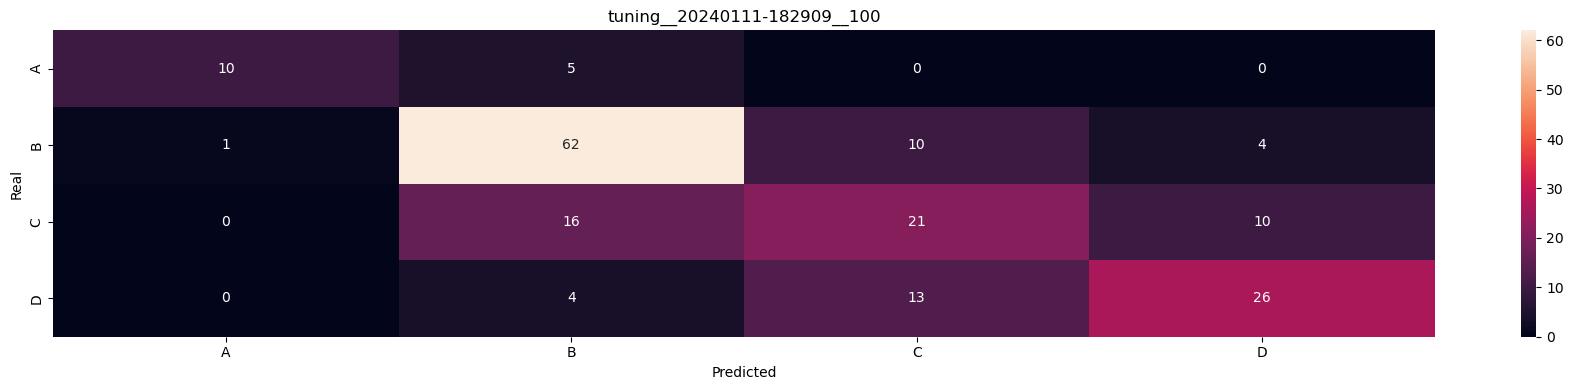

In [20]:
out = BNTuning.get_k_best_trials(study, k=1,save_kaggle=True);

In [110]:
out["tuning__20240111-165637__615"]["params"]

{'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 22,
 'delete_correlated': False,
 'resample': False,
 'n_neighbors': 17,
 'weights': 'uniform',
 'metric': 'manhattan'}